In [21]:
### NOTE FROM 2020-06-07:
### This notebook is complete, and produces the Sina plots and Strip plots
###     with barplots underneath. Moving on to only producing barplots, as
###     we decided the sina/stripplots didn't add any information


import os
from datetime import datetime
today = datetime.now().strftime('%Y-%m-%d')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sinaplot import sinaplot



%matplotlib inline
sns.set(style="whitegrid", palette="pastel", color_codes=True, font='Helvetica')

# Set font sizes
SMALL_SIZE = 6
MEDIUM_SIZE = 7
BIG_SIZE = 8

plt.rcParams.update({
    'legend.loc': 'center left',
    'font.family': 'Helvetica',
    'font.size': BIG_SIZE,         # controls default text sizes
    'axes.titlesize': SMALL_SIZE,  # fontsize of the axes title
    'axes.labelsize': MEDIUM_SIZE, # fontsize of the x and y labels
    'xtick.labelsize': SMALL_SIZE, # fontsize of the tick labels
    'ytick.labelsize': SMALL_SIZE, # fontsize of the tick labels
    'legend.fontsize': SMALL_SIZE, # legend fontsize
    'figure.titlesize': BIG_SIZE   # fontsize of the figure title
})

In [24]:
# Gsp1 sequence
WT_seq = 'MSAPAANGEVPTFKLVLVGDGGTGKTTFVKRHLTGEFEKKYIATIGVEVHPLSFYTNFGE' \
         'IKFDVWDTAGQEKFGGLRDGYYINAQCAIIMFDVTSRITYKNVPNWHRDLVRVCENIPIV' \
         'LCGNKVDVKERKVKAKTITFHRKKNLQYYDISAKSNYNFEKPFLWLARKLAGNPQLEFVA' \
         'SPALAPPEVQVDEQLMQQYQQEMEQATALPLPDEDDADL*'

# secondary structure
gsp1_ss = (
    pd.read_csv('../Data/ss_df_wide.csv')
    [['aa_position', 'consensus_ss']]
    .rename(columns={'aa_position': 'position'})
) 

# read in fitness data
EMPIRIC_df = pd.read_csv('../Data/15gen_binned_0607.csv')

def dict_of_lists_to_long_table(d, var_name, value_name, value_type):
    return(pd.DataFrame.from_dict(data=d, orient='index')
    .transpose()
    .melt(var_name=var_name, value_name=value_name)
    .dropna()
    .assign(position=lambda x: x[value_name].astype(value_type))
    .reindex(columns=[value_name,var_name])
    )

outdir = '../Mathy_plots/python_plots/sinaplots_{}'.format(today)
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [25]:
def plot_regions_by_bins(file, df, x, y='score', hue='bin', order=None,
                         plot = ['sina', 'strip'], title='', w=5, h=5):
    
    bin_order = ['toxic', 'STOP-like', 'intermediate', 'neutral', 'beneficial']
    
    # prepare figure
    fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [2,1]})
    fig.suptitle(title) 

    plt.sca(axs[0])    

    if plot is 'sina':
        sinaplot(data=df, x=x, y=y, hue=hue,
                 palette=sns.color_palette('RdBu', n_colors=7)[:5],
                 order=order, hue_order=bin_order,
                 alpha = 0.5, scale='count', violin=False,
                 point_size = 2, point_linewidth=0.1, point_edgecolor='black')
        
    if plot is 'strip':
        sns.violinplot(data=df, x=x, y=y, color = 'white', cut=0,
                   order=order, alpha = 0.3, scale='count', linewidth=0.5)

        sns.stripplot(data=df, x=x, y=y, hue=hue,
                      order=order, hue_order=bin_order,
                      palette=sns.color_palette('RdBu', n_colors=7)[:5],
                      size = 2, linewidth=0.1, edgecolor='black')
        
    
    plt.xlabel('')
    plt.ylabel('Selection Coefficient')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=0.5)


    # plot bar charts

    bin_order = ['drop-outs', 'toxic', 'STOP-like', 'intermediate', 'neutral', 'beneficial']
    
    plt.sca(axs[1])
    percent = (df
               .assign(bin = lambda df: df.bin.apply(
                   lambda row: 'drop-outs' if pd.isnull(row) else row))
               .groupby(x)
               [hue]
               .value_counts(normalize=True, dropna=False)
               .rename('score')
               .reset_index())
    
    g = sns.barplot(data=percent, x=x, y=y, hue=hue,
                    order=region_order, hue_order=bin_order,
                    palette=['black']+sns.color_palette('RdBu', n_colors=7)[:5],
                    edgecolor='black', linewidth=0.5)
            
    plt.xlabel('Mutation positions')
    plt.ylabel('Fraction of \nSelection Coefficients')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.set_size_inches(w, h)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    
    # add counts to bars
#     counts = (df
#              [hue]
#              .mask(df.bin.isnull(), 'drop-outs')
#              .groupby(df[x])
#              .count())
    
#     for p in axs[1].patches:
#         _x = p.get_x() + p.get_width() / 2
#         _y = p.get_y() + p.get_height()

#         if np.isnan(p.get_height()):
#             _y = p.get_y()
#         else:
#             _y = p.get_y() + p.get_height()
#         value = '{:.2f}'.format(_y)
#         axs[1].text(_x + 0.01, _y + 0.02, value, va='bottom', ha='center', size=5, rotation=90) 
    
    
    fig.savefig(file, dpi=300)
    
    return

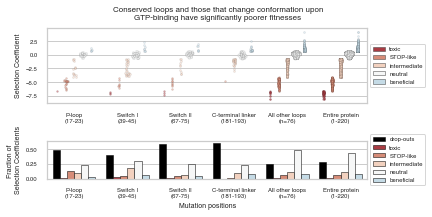

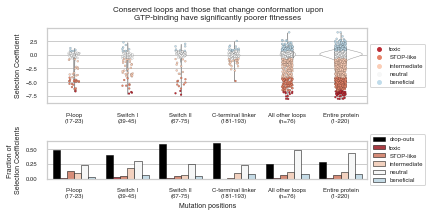

In [27]:
# Sinaplot and barplot of conserved/switch loops

# define loops based on residue positions
# NOTE: leave out C-term helix (194-208) bc it matches the entire protein dist,
# and it's really the C-term linker that switches conformation
loops = {
    'P-loop\n(17-23)': list(range(17, 23+1)),
    'Switch I\n(39-45)':  list(range(39, 45+1)),
    'Switch II\n(67-75)': list(range(67, 75+1)),
    'C-terminal linker\n(181-193)': list(range(181,193+1)),
}


all_loop_pos = gsp1_ss[gsp1_ss.consensus_ss == 'L']['position']
func_loop_pos = set([pos for sublist in list(loops.values()) for pos in sublist])  # just unnests the lists in the dict
loops['All other loops\n(n=76)'] = [pos for pos in all_loop_pos if pos not in func_loop_pos]
loops['Entire protein\n(1-220)'] = list(range(1, 220+1))
loops_df = dict_of_lists_to_long_table(
    d=loops, var_name='loop', value_name='position', value_type='int'
)

# merge loop annotations into dataset
df = EMPIRIC_df.merge(loops_df, on='position')

# set ordering of levels in plots
region_order = ['P-loop\n(17-23)', 'Switch I\n(39-45)',
                'Switch II\n(67-75)', 'C-terminal linker\n(181-193)',
                'All other loops\n(n=76)', 'Entire protein\n(1-220)']
title = ('Conserved loops and those that change conformation upon\n'
         'GTP-binding have significantly poorer fitnesses')
w, h = 6, 3
region = 'loop'

for plot_type in ['sina', 'strip']:    
    plot_regions_by_bins(
        file=os.path.join(outdir,'{}_{}_plots.png'.format(region, plot_type)),
        df=df, x=region, title=title, w=w, h=h, plot=plot_type, order=region_order)


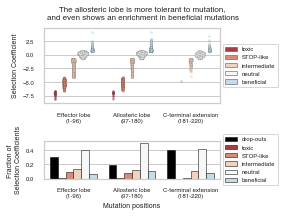

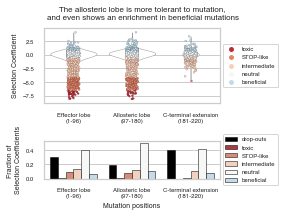

In [28]:
# Sinaplot and barplot of lobes

# define loops based on residue positions
lobes = {
    'Effector lobe\n(1-96)': list(range(1, 96+1)),
    'Allosteric lobe\n(97-180)': list(range(97,180+1)),
    'C-terminal extension\n(181-220)': list(range(181, 220+1))
}
lobes_df = dict_of_lists_to_long_table(
    d=lobes, var_name='lobe', value_name='position', value_type='int'
)

# merge lobes annotations into dataset
df = EMPIRIC_df.merge(lobes_df, on='position')

# plot settings
region_order = ['Effector lobe\n(1-96)', 'Allosteric lobe\n(97-180)', 'C-terminal extension\n(181-220)']
title = ('The allosteric lobe is more tolerant to mutation,\n'
         'and even shows an enrichment in beneficial mutations') 
w, h = 4, 3
region = 'lobe'

for plot_type in ['sina', 'strip']:    
    plot_regions_by_bins(
        file=os.path.join(outdir,'{}_{}_plots.png'.format(region, plot_type)),
        df=df, x=region, title=title, w=w, h=h, plot=plot_type, order=region_order)

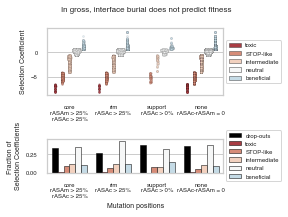

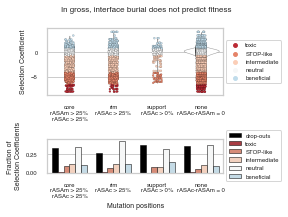

In [29]:
interfaces = (
    pd.read_csv('../Data/interface_residues_and_mutations.txt', sep='\t')
    .rename(columns={'yeastresnum':'position'})
)

interface_names = {
  'core': '\n'.join(['core', 'rASAm > 25%', 'rASAc > 25%']),
  'rim': '\n'.join(['rim', 'rASAc > 25%']),
  'support': '\n'.join(['support', 'rASAc > 0%']),
  'none': '\n'.join(['none', 'rASAc-rASAm = 0'])}

df = (EMPIRIC_df
      .merge(interfaces, on='position', how='left')
      .replace({'interface': interface_names})
     )

# plot settings
region_order = [interface_names['core'], interface_names['rim'],
                interface_names['support'], interface_names['none']]
title = ('In gross, interface burial does not predict fitness') 
w, h = 4, 3
region = 'interface'

for plot_type in ['sina', 'strip']:    
    plot_regions_by_bins(
        file=os.path.join(outdir,'{}_{}_plots.png'.format(region, plot_type)),
        df=df, x=region, title=title, w=w, h=h, plot=plot_type, order=region_order)